<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## RNN one-to-one

#### Datos
El objecto es utilizar una serie de sucuencias númericas (datos sintéticos) para poner a prueba el uso de las redes RNN. Este ejemplo se inspiró en otro artículo, lo tienen como referencia en el siguiente link:\
[LINK](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/)

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

  Obtaining dependency information for torchinfo from https://files.pythonhosted.org/packages/72/25/973bd6128381951b23cdcd8a9870c6dcfc5606cb864df8eabd82e529f9c1/torchinfo-1.8.0-py3-none-any.whl.metadata


In [3]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

curl: (3) URL using bad/illegal format or missing URL
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 34 23883   34  8226    0     0   8890      0  0:00:02 --:--:--  0:00:02  8921
100 23883  100 23883    0     0  25025      0 --:--:-- --:--:-- --:--:-- 25113


In [30]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    valid_loss = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Valid Loss {epoch_valid_loss:.3f}")

    history = {
        "loss": train_loss,
        "val_loss": valid_loss,
    }
    return history

In [31]:
# Generar datos sintéticos
X = list()
y = list()
X = [x+1 for x in range(20)]

# "y" (target) se obtiene como cada dato de entrada multiplicado por 15
y = [x * 15 for x in X]

print("datos X:", X)
print("datos y:", y)

datos X: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
datos y: [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270, 285, 300]


In [32]:
# Cada dato X lo transformarmos en una matriz de 1 fila 1 columna (1x1)
X = np.array(X).reshape(len(X), 1, 1)
print("datos X:", X)

datos X: [[[ 1]]

 [[ 2]]

 [[ 3]]

 [[ 4]]

 [[ 5]]

 [[ 6]]

 [[ 7]]

 [[ 8]]

 [[ 9]]

 [[10]]

 [[11]]

 [[12]]

 [[13]]

 [[14]]

 [[15]]

 [[16]]

 [[17]]

 [[18]]

 [[19]]

 [[20]]]


In [33]:
# (batch size, seq_len, input_size)
X.shape

(20, 1, 1)

In [34]:
y = np.asanyarray(y)
y.shape

(20,)

In [35]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss unfction esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float().view(-1, 1)

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_dim = data_set.x.shape[1:]
seq_length = input_dim[0]
input_size = input_dim[1]
print("Input dim", input_dim)
print("seq_length:", seq_length)
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim torch.Size([1, 1])
seq_length: 1
input_size: 1
Output dim 1


In [36]:
data_set.x.shape

torch.Size([20, 1, 1])

In [37]:
data_set.y.shape

torch.Size([20, 1])

In [38]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

# Cuando trabajmos con una serie temporal no mezclamos (shuffle) los datos
train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 16
Tamaño del conjunto de validacion: 4


### 2 - Entrenar el modelo (RNN y LSTM)

In [39]:
from torch_helpers import CustomRNN

class Model1(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()

        #self.rnn1 = nn.RNN(input_size=input_size, hidden_size=64, batch_first=True) # RNN layer
        # Utilizamos la CustomRNN ya que para series temporales suele funcionar mejor
        # la activacion "relu" en las RNN en vez de la "tanh", pero por defecto la
        # layer de Pytorch RNN no permite modificar la funcion de activacion
        #self.rnn1 = CustomRNN(input_size=input_size, hidden_size=64) # RNN layer
        self.rnn1 = CustomRNN(input_size=input_size, hidden_size=64, activation=nn.ReLU()) # RNN layer
        self.fc = nn.Linear(in_features=64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.rnn1(x)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model1 = Model1(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
model1_criterion = nn.MSELoss()  # mean squared error

summary(model1, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1]                    --
├─CustomRNN: 1-1                         [1, 1, 64]                4,224
│    └─ReLU: 2-1                         [1, 64]                   --
├─Linear: 1-2                            [1, 1]                    65
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [40]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 21055.309 - Valid Loss 76896.086
Epoch: 2/500 - Train loss 20922.094 - Valid Loss 76426.508
Epoch: 3/500 - Train loss 20790.615 - Valid Loss 75947.938
Epoch: 4/500 - Train loss 20654.363 - Valid Loss 75444.773
Epoch: 5/500 - Train loss 20511.916 - Valid Loss 74911.000
Epoch: 6/500 - Train loss 20361.346 - Valid Loss 74343.531
Epoch: 7/500 - Train loss 20200.094 - Valid Loss 73724.578
Epoch: 8/500 - Train loss 20024.904 - Valid Loss 73053.656
Epoch: 9/500 - Train loss 19835.967 - Valid Loss 72327.805
Epoch: 10/500 - Train loss 19631.406 - Valid Loss 71543.961
Epoch: 11/500 - Train loss 19410.629 - Valid Loss 70700.086
Epoch: 12/500 - Train loss 19172.973 - Valid Loss 69792.797
Epoch: 13/500 - Train loss 18917.514 - Valid Loss 68820.148
Epoch: 14/500 - Train loss 18643.729 - Valid Loss 67781.375
Epoch: 15/500 - Train loss 18351.445 - Valid Loss 66675.812
Epoch: 16/500 - Train loss 18040.500 - Valid Loss 65503.141
Epoch: 17/500 - Train loss 17710.822 - Valid Loss

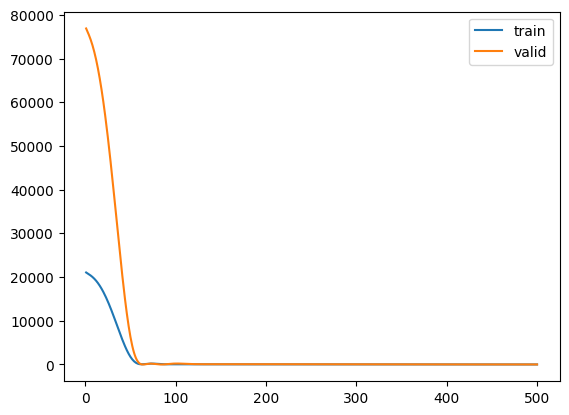

In [41]:
epoch_count = range(1, len(history1['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history1['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='valid')
plt.show()

In [42]:
# Ensayo
# x = 30
# y_test = x * 15

x_test = 30
y_test = x_test * 15
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model1(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model1_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: 450
y_hat: tensor([[443.0439]], grad_fn=<AddmmBackward0>)
loss: 48.387969970703125


In [43]:
from torch_helpers import CustomLSTM

class Model2(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()

        #self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True) # LSTM layer
        # Utilizamos la CustomLSTM ya que para series temporales suele funcionar mejor
        # la activacion "relu" en las LSTM en vez de la "tanh", pero por defecto la
        # layer de Pytorch LSTM no permite modificar la funcion de activacion
        self.lstm1 = CustomLSTM(input_size=input_size, hidden_size=64, activation=nn.ReLU()) # LSTM layer
        self.fc = nn.Linear(in_features=64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.lstm1(x)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model2 = Model2(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
model2_criterion = nn.MSELoss()  # mean squared error

summary(model2, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 1]                    --
├─CustomLSTM: 1-1                        [1, 1, 64]                16,896
│    └─Sigmoid: 2-1                      [1, 64]                   --
│    └─Sigmoid: 2-2                      [1, 64]                   --
│    └─ReLU: 2-3                         [1, 64]                   --
│    └─Sigmoid: 2-4                      [1, 64]                   --
│    └─ReLU: 2-5                         [1, 64]                   --
├─Linear: 1-2                            [1, 1]                    65
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [44]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 21066.238 - Valid Loss 77210.188
Epoch: 2/500 - Train loss 21021.455 - Valid Loss 77020.969
Epoch: 3/500 - Train loss 20973.658 - Valid Loss 76810.289
Epoch: 4/500 - Train loss 20920.668 - Valid Loss 76561.188
Epoch: 5/500 - Train loss 20858.859 - Valid Loss 76265.078
Epoch: 6/500 - Train loss 20787.156 - Valid Loss 75918.555
Epoch: 7/500 - Train loss 20703.875 - Valid Loss 75515.391
Epoch: 8/500 - Train loss 20607.242 - Valid Loss 75048.805
Epoch: 9/500 - Train loss 20495.682 - Valid Loss 74514.375
Epoch: 10/500 - Train loss 20367.816 - Valid Loss 73908.453
Epoch: 11/500 - Train loss 20222.318 - Valid Loss 73228.125
Epoch: 12/500 - Train loss 20057.967 - Valid Loss 72471.617
Epoch: 13/500 - Train loss 19873.768 - Valid Loss 71638.234
Epoch: 14/500 - Train loss 19668.932 - Valid Loss 70728.258
Epoch: 15/500 - Train loss 19442.809 - Valid Loss 69742.562
Epoch: 16/500 - Train loss 19194.949 - Valid Loss 68682.812
Epoch: 17/500 - Train loss 18925.117 - Valid Loss

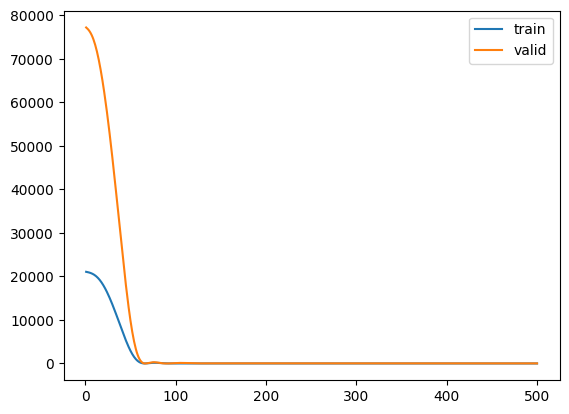

In [45]:
epoch_count = range(1, len(history2['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_loss'], label='valid')
plt.show()

In [46]:
# Ensayo
# x = 30
# y_test = x * 15

x_test = 30
y_test = x_test * 15
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model2(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model2_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: 450
y_hat: tensor([[434.6496]], grad_fn=<AddmmBackward0>)
loss: 235.63580322265625


Se puede observar que para un problema tan simple como este no hay mucha diferencia entre utilizar una RNN o LSTM. La LSTM tiene muchos más parámetros que la RNN.

### 3 - Multi-layer LSTM

In [47]:
from torch_helpers import CustomLSTM

# En esta oportunidad se utilizarán dos layer LSTM
class Model3(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()

        self.lstm1 = CustomLSTM(input_size=input_size, hidden_size=64, activation=nn.ReLU()) # LSTM layer
        self.lstm2 = CustomLSTM(input_size=64, hidden_size=64, activation=nn.ReLU()) # LSTM layer
        self.fc = nn.Linear(in_features=64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.lstm1(x)
        lstm_output, _ = self.lstm2(lstm_output)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model3 = Model3(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model3_optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)
model3_criterion = nn.MSELoss()  # mean squared error

summary(model3, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model3                                   [1, 1]                    --
├─CustomLSTM: 1-1                        [1, 1, 64]                16,896
├─CustomLSTM: 1-4                        --                        (recursive)
│    └─Sigmoid: 2-1                      [1, 64]                   --
│    └─Sigmoid: 2-2                      [1, 64]                   --
├─CustomLSTM: 1-5                        --                        (recursive)
│    └─ReLU: 2-3                         [1, 64]                   --
├─CustomLSTM: 1-4                        --                        (recursive)
│    └─Sigmoid: 2-4                      [1, 64]                   --
├─CustomLSTM: 1-5                        --                        (recursive)
│    └─ReLU: 2-5                         [1, 64]                   --
├─CustomLSTM: 1-6                        [1, 1, 64]                33,024
│    └─Sigmoid: 2-6                      

In [48]:
history3 = train(model3,
                train_loader,
                valid_loader,
                model3_optimizer,
                model3_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 21060.648 - Valid Loss 77298.312
Epoch: 2/500 - Train loss 21046.730 - Valid Loss 77250.477
Epoch: 3/500 - Train loss 21032.021 - Valid Loss 77168.922
Epoch: 4/500 - Train loss 21010.311 - Valid Loss 77025.742
Epoch: 5/500 - Train loss 20976.109 - Valid Loss 76770.383
Epoch: 6/500 - Train loss 20920.223 - Valid Loss 76333.898
Epoch: 7/500 - Train loss 20830.010 - Valid Loss 75630.602
Epoch: 8/500 - Train loss 20688.035 - Valid Loss 74578.234
Epoch: 9/500 - Train loss 20472.715 - Valid Loss 73123.422
Epoch: 10/500 - Train loss 20161.223 - Valid Loss 71247.359
Epoch: 11/500 - Train loss 19733.873 - Valid Loss 68939.000
Epoch: 12/500 - Train loss 19177.111 - Valid Loss 66161.914
Epoch: 13/500 - Train loss 18481.977 - Valid Loss 62845.211
Epoch: 14/500 - Train loss 17639.088 - Valid Loss 58900.336
Epoch: 15/500 - Train loss 16639.480 - Valid Loss 54279.516
Epoch: 16/500 - Train loss 15471.961 - Valid Loss 48960.656
Epoch: 17/500 - Train loss 14127.237 - Valid Loss

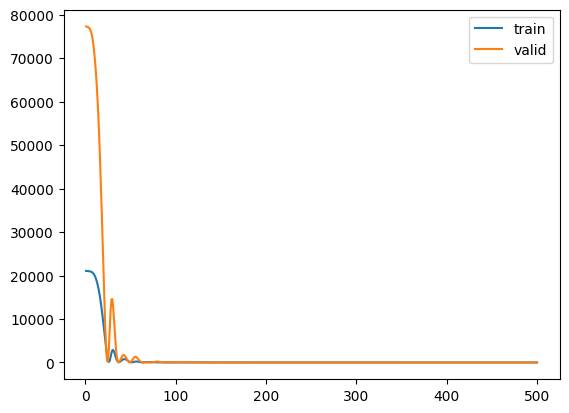

In [49]:
epoch_count = range(1, len(history3['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history3['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history3['val_loss'], label='valid')
plt.show()

In [50]:
# Ensayo
# x = 30
# y_test = x * 15

x_test = 30
y_test = x_test * 15
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model3(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model3_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: 450
y_hat: tensor([[437.8927]], grad_fn=<AddmmBackward0>)
loss: 146.5874481201172


### 4 - Conclusión
El resultado alcanzado es bueno pero podría mejorarse agregando más layer LSTM o más layer fully connected.